In [ ]:
import sys
from pathlib import Path
import datetime as dt
import numpy as np 
import pandas as pd
import json
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

ML_LOC = PROJPATH / "data/ML_2024"
locpath = PROJPATH / "data/breakupdata/derived/breakupDate_mean_std_HUC_augmented.csv"

startyr = 1980  # start year for training data
endyr = 2023    # end year for training data
predyr = 2024   # year for which we predict

####  load list of locations

In [ ]:
huctable_aug = pd.read_csv(locpath, index_col=0)
huctable_aug.sort_values(['river', 'mean_days'], inplace=True)
huctable_aug.siteID


33            Buckland River at Buckland
37              Chena River at Fairbanks
38             Chisana River at Northway
0                 Gakona River at Gakona
1                Gulkana River nr Gakona
7                   Kobuk River at Kobuk
8                Kobuk River at Shungnak
6                  Kobuk River at Ambler
35              Koyukuk River at Bettles
34            Koyukuk River at Allakaket
36               Koyukuk River at Hughes
19            Kuskokwim River at Nikolai
20          Kuskokwim River at Sleetmute
21        Kuskokwim River at Stony River
31          Kuskokwim River at Red Devil
29      Kuskokwim River at Crooked Creek
18            Kuskokwim River at McGrath
27              Kuskokwim River at Aniak
30            Kuskokwim River at Kalskag
32           Kuskokwim River at Tuluksak
26              Kuskokwim River at Akiak
28             Kuskokwim River at Bethel
9              Susitna River at Sunshine
39                Tanana River at Nenana
40    Tanana Riv

#### Component functions

In [ ]:
def get_Xy(location):
    df = pd.read_csv(ML_LOC / f"DF/DF_{location.replace(' ', '_')}", index_col=0)
    df.rename(columns={'t2m': 't2m_M', 'ssr': 'ssr_M', 'sd': 'sd_M'}, inplace=True)
    Xy = df.loc[1980:2023, :].dropna()
    # Xy.reset_index(inplace=True, names='year')
    X = Xy.iloc[:, :-1]
    y = Xy.iloc[:, -1]
    X_pred = df.iloc[-1, :-1]

In [ ]:
location = "Chena River at Fairbanks"

# X_2024 = df.reset_index(names='year').iloc[-1, :-1]

#### Feature selection

In [ ]:

clf = ExtraTreesRegressor(n_estimators=200, random_state=42)
clf = clf.fit(X, y)
clf.feature_importances_
selector = SelectFromModel(clf, prefit=True)
X_new = X[X.columns[selector.get_support()]]
X_new

,AO_DJ,AO_FM,PNA_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick,sd_M
1983,1.163,-1.187,0.660,0.450,0.280,-0.705,-1.035,0.030,39.755556,0.128
1985,-1.180,-0.444,-0.230,-0.795,-0.860,-0.350,-1.405,-0.120,39.755556,0.160
1986,-1.258,-0.486,0.840,-0.245,-0.195,-0.130,-0.020,1.535,39.755556,0.085
1988,-0.135,-0.632,0.265,0.705,0.295,-0.215,0.730,-0.090,39.755556,0.093
1989,2.393,2.405,-0.620,-1.745,-1.345,-0.200,0.165,0.790,42.000000,0.121
1990,0.178,3.196,-0.260,0.020,0.345,1.430,-0.645,0.070,36.000000,0.178
1991,1.000,-0.702,-0.710,0.615,0.440,0.425,0.550,0.175,38.000000,0.270
1993,2.561,0.474,-1.505,0.145,0.075,-0.925,0.540,1.685,26.000000,0.232
1995,0.370,0.911,0.295,0.820,0.710,-0.715,0.695,-0.165,34.000000,0.167
1996,-1.663,-0.660,-0.030,-0.485,-0.460,-0.885,-0.180,1.635,45.000000,0.113


In [ ]:
X_new.corrwith(y)

AO_DJ            -0.407813
AO_FM            -0.276093
PNA_DJ            0.103629
Nino4_DJ         -0.334465
Nino4_FM         -0.382796
EA_FM            -0.081002
POL_DJ           -0.251870
POL_FM           -0.193658
NenanaIceThick    0.424256
sd_M             -0.335160
dtype: float64

Straight CV

In [ ]:
saveplots = True
summary = {}
summary['location'] = location
summary['predictors'] = list(X_new.columns)

In [ ]:
X_new

,AO_DJ,AO_FM,PNA_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick,sd_M
1983,1.163,-1.187,0.660,0.450,0.280,-0.705,-1.035,0.030,39.755556,0.128
1985,-1.180,-0.444,-0.230,-0.795,-0.860,-0.350,-1.405,-0.120,39.755556,0.160
1986,-1.258,-0.486,0.840,-0.245,-0.195,-0.130,-0.020,1.535,39.755556,0.085
1988,-0.135,-0.632,0.265,0.705,0.295,-0.215,0.730,-0.090,39.755556,0.093
1989,2.393,2.405,-0.620,-1.745,-1.345,-0.200,0.165,0.790,42.000000,0.121
1990,0.178,3.196,-0.260,0.020,0.345,1.430,-0.645,0.070,36.000000,0.178
1991,1.000,-0.702,-0.710,0.615,0.440,0.425,0.550,0.175,38.000000,0.270
1993,2.561,0.474,-1.505,0.145,0.075,-0.925,0.540,1.685,26.000000,0.232
1995,0.370,0.911,0.295,0.820,0.710,-0.715,0.695,-0.165,34.000000,0.167
1996,-1.663,-0.660,-0.030,-0.485,-0.460,-0.885,-0.180,1.635,45.000000,0.113


In [ ]:
# load model 
modeldir = ML_LOC / 'models'
filename = f'{location}_joblib_model.sav'
best_model = joblib.load(modeldir / filename)


... or calculate it 

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=43)
model = GradientBoostingRegressor(random_state=40)
    # define search space
space = {
        # 'min_samples_leaf': list(range(3, 7)),
        'min_samples_leaf': [4],
        'min_samples_split': [2, 3],
        'max_depth': [2, 3, 4],
        'n_estimators': [1000],
        'learning_rate': [0.02, 0.015, 0.01, 0.001],
        'subsample': [0.5],
    }
# define search
search = GridSearchCV(model, space, cv=cv_inner, scoring='neg_mean_absolute_error', verbose=1, 
            refit=True, n_jobs=6)
# execute search
grid_result = search.fit(X, y)
# get the best performing model fit on the whole training set
best_model = grid_result.best_estimator_
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev}, {param}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
-4.841239536417039, 1.1546657491059429, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 0.5}
-4.841239536417039, 1.1546657491059429, {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 1000, 'subsample': 0.5}
-4.841239536417039, 1.1546657491059429, {'learning_rate': 0.02, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 0.5}
-4.841239536417039, 1.1546657491059429, {'learning_rate': 0.02, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 1000, 'subsample': 0.5}
-4.841239536417039, 1.1546657491059429, {'learning_rate': 0.02, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 0.5}
-4.841239536417039, 1.1546657491059429, {'learning_rate': 0.02, 'max_depth': 4, 'min_samples_leaf': 4, 

In [ ]:
grid_result.cv_results_['mean_test_score'][grid_result.best_index_]

-4.697661521295609

In [ ]:
best_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'squared_error',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
summary['modelparams'] = best_model.get_params()
summary['rms_cv'] = - grid_result.cv_results_['mean_test_score'][grid_result.best_index_]
summary['rms_std_cv'] = grid_result.cv_results_['std_test_score'][grid_result.best_index_]

The mean squared error (MSE) on train set: 9.4959
The mean squared error (MSE) on test set: 33.1150
The score for this training set is 0.8789
The validation score for this test set is -2.4782
Pearson score on training set: 0.9565
Pearson score on test set: 0.0086



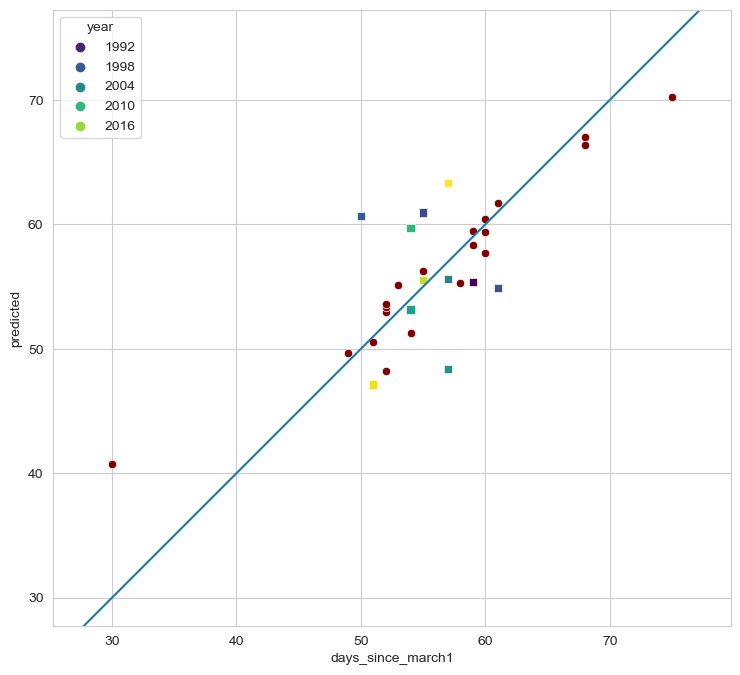

In [ ]:
random_seed = 2023
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=random_seed)

params_gb = {
        'min_samples_leaf': 4,
        'min_samples_split': 3,
        'max_depth': 4,
        # 'n_estimators': [250, 200, 150, 100],
        'n_estimators': 5000,
        'learning_rate': 0.001,
        'subsample': 0.5,
    'random_state': random_seed, 
}
model1 = GradientBoostingRegressor(**params_gb)
model2 = RandomForestRegressor(random_state=random_seed)
model2 = best_model
model3 = ExtraTreesRegressor(n_estimators=200)
# define search
model = VotingRegressor(estimators=[('gb', model1), ('rf', model2), ('lr', model3)])
model = model2
# execute search
result = model.fit(X_train, y_train)
# get the best performing model fit on the whole training set
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True)
# sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
# sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
# sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
# sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='maroon', ax=ax)
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, hue='year', marker='s', palette='viridis', ax=ax)
lims = ax.get_xlim()
ax.set_ylim(lims)
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]])
ax.set_aspect('equal')
plt.show(fig)
if saveplots:
    outdir = ML_LOC / "overfitting_tests"
    fn = f"{location.replace(' ', '_')}_overfit.png"
    fig.savefig(outdir / fn, bbox_inches='tight')

In [ ]:
model.score(X_new, y)

0.6701037541853008

In [ ]:
model.score(X_train, y_train)

0.8789403881899633

In [ ]:
model.score(X_test, y_test)

-2.478222980676592

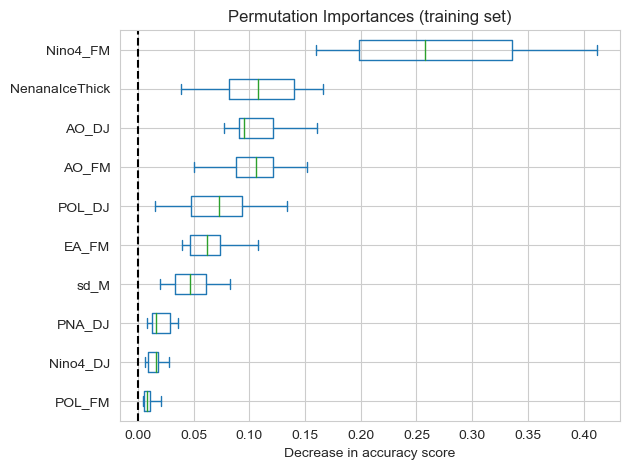

In [ ]:
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (training set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_train.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

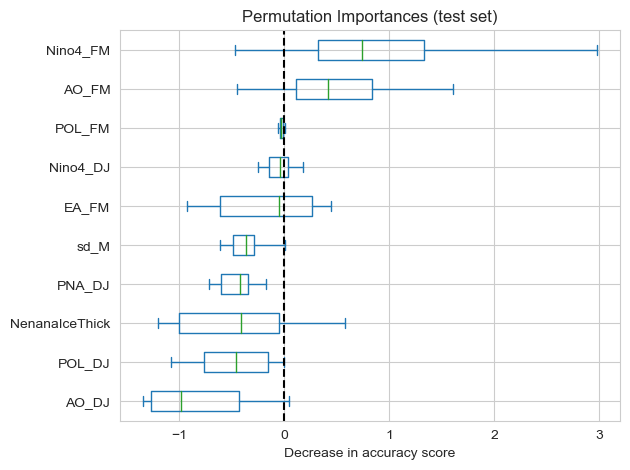

In [ ]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_test.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
sns.set_style('whitegrid')

The mean squared error (MSE) on train set: 2.6109
The mean squared error (MSE) on test set: 86.5166
The score for this training set is 0.9186
The validation score for this test set is 0.2275
Pearson score on training set: 0.9732
Pearson score on test set: 0.6209



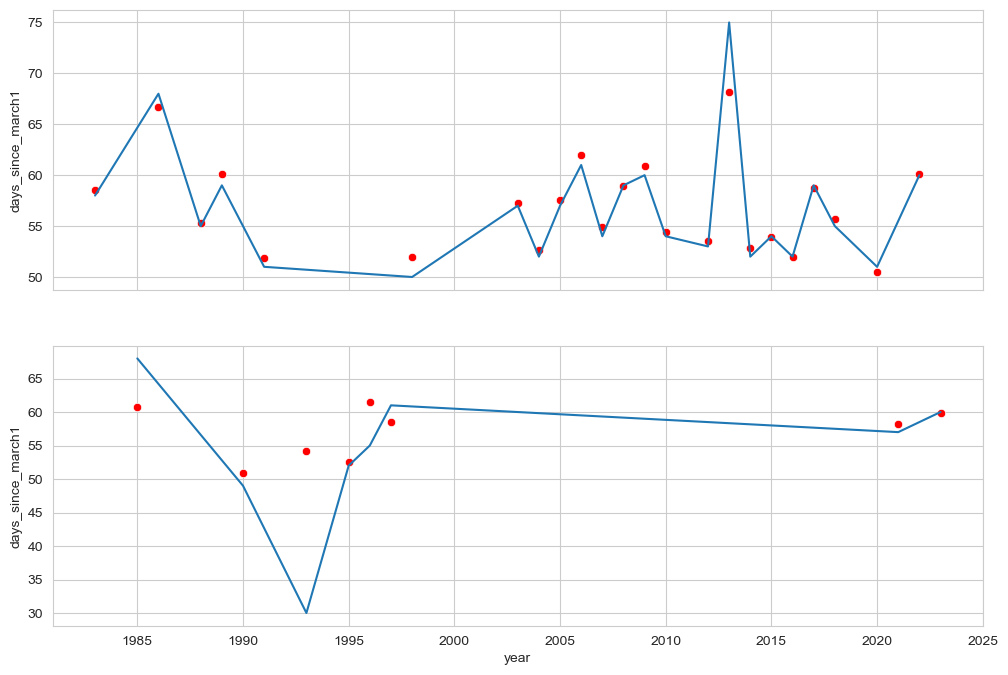

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = best_model

model.fit(X_train, y_train)
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='blue', ax=ax)
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, color='red', ax=ax)
# ax.set_box_aspect(1)
plt.show(fig)

In [ ]:
best_model.fit(X_new, y)
prediction = best_model.predict(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
since_date = dt.datetime.strptime('202403011200', "%Y%m%d%H%M")
preddate = (since_date + dt.timedelta(days=prediction.item())).date().strftime("%Y-%m-%d")

summary['prediction_2024'] = prediction.item()
summary['pred_date_2024'] = preddate

preddate



# ru.dayssince2date(prediction.item())

'2024-04-22'

In [ ]:
summary

{'location': 'Chena River at Fairbanks',
 'predictors': ['AO_DJ',
  'AO_FM',
  'PNA_DJ',
  'Nino4_DJ',
  'Nino4_FM',
  'EA_FM',
  'POL_DJ',
  'POL_FM',
  'NenanaIceThick',
  'sd_M'],
 'prediction_2024': 52.40024835418363,
 'pred_date_2024': '2024-04-22',
 'modelparams': {'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.01,
  'loss': 'squared_error',
  'max_depth': 2,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1000,
  'n_iter_no_change': None,
  'random_state': 40,
  'subsample': 0.5,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 0,
  'warm_start': False},
 'rms_cv': 4.697661521295609,
 'rms_std_cv': 1.1661016429317619}

In [ ]:
pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T

,AO_DJ,AO_FM,PNA_DJ,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick,sd_M
2024,-0.216,0.013,0.415,1.52,1.125,1.7,-0.91,-1.84,49.0,0.087


### Shaply analysis

In [ ]:
import shap

In [ ]:
X_sample = shap.utils.sample(X_new, 50)

In [ ]:
explainer = shap.Explainer(best_model.predict, X_new)
shap_values = explainer(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
shap_values_all = explainer(X_new)
sample_ind = 20

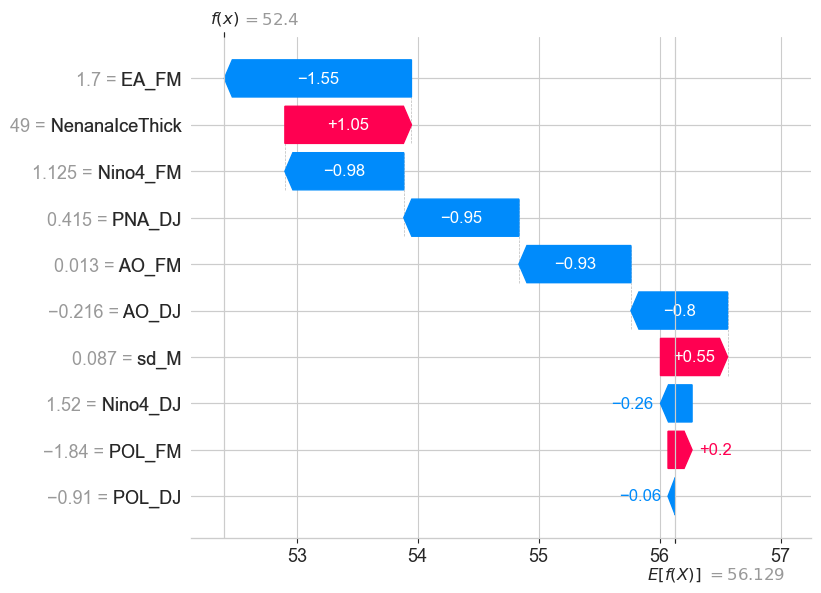

In [ ]:
ax = shap.plots.waterfall(shap_values[0], max_display=20, show=False)
# ax.set_title(f"2024, {location}")
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_waterfall_2024.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

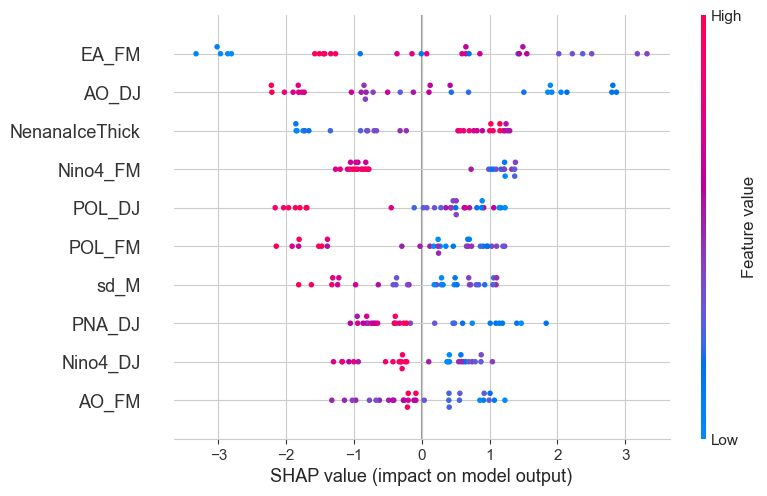

In [ ]:
shap.plots.beeswarm(shap_values_all, max_display=25, show=False)

if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_beehive.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
if saveplots:

    modeldir = ML_LOC / 'models'
    filename = f"{location.replace(' ', '_')}_joblib_model.sav"
    joblib.dump(model, modeldir / filename)
    summarydir =ML_LOC / 'model_eval'
    summaryfn = f"{location.replace(' ', '_')}_modelsummary.json"
    with open(summarydir / summaryfn, 'w' ) as dst: 
        json.dump(summary, dst, indent=2)


SyntaxError: f-string: unmatched '(' (4050906666.py, line 4)